# Iteration of complex polynomials with Python

In this little Jupyter notebook, we implement a simple algorithm for generating the filled Julia set of a polynomial and shading the basin of attraction of $\infty$. The mathematical
justification of the algorithm is presented in [our class notes](http://marksmath.org/classes/Spring2017ComplexDynamics/handouts/complex_iteration_examples/section-polynomial_algorithm.html).

It's probably worth mentioning that Python is about as readable as programming languages go and, therefore, makes a good choice to introduce this kind of algorithm. It does have a few quirks. Notably, exponentiation is entered with a double asterix. Thus, $z^2$ is entered as `z**2`.

### Load some libraries

The libraries we need are all included with Anaconda.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from time import time # It's nice to know how fast our code runs
from numba import jit # Just in time compilation

### Define the function of interest and set some parameters

In [7]:
g = (1+np.sqrt(5))/2


@jit(nopython=True)
def f(z): return np.exp(2j*np.pi*g)*z+z**2

#def f(z): return z**2 - 0.123 + 0.745j

zmin = -1.5-1j
zmax = 2+1.5j
max_iters = 500
max_size_squared = 20
resolution = 1200

In [12]:
@jit(nopython=True)
def f(z): return (-0.090706 + 0.27145j) + (2.41154-0.133695j)*z**2 - z**3

zmin = -1.5-1j
zmax = 3+1j
max_iters = 100
max_size_squared = 20
resolution = 1000

### Everything else should be good to run

In [13]:
@jit(nopython=True)
def orbit_cnt(z0, max_iters, max_size_squared):
    z = z0
    cnt = 0
    while cnt < max_iters and z.real**2 + z.imag**2 <= max_size_squared:
        cnt = cnt + 1
        z = f(z)
    return cnt

@jit(nopython=True)
def generate_counts(zmin,zmax, max_iters, max_size_squared, resolution):
    xs = [zmin.real, zmax.real]
    xs.sort()
    xmin,xmax = xs
    ys = [zmin.imag, zmax.imag]
    ys.sort()
    ymin,ymax = ys
    xrange = xmax-xmin
    yrange = ymax-ymin
    if xrange >= yrange:
        xdim = int(resolution)
        ydim = int(xdim*(yrange/xrange))
        delta = xrange/xdim
    else:
        ydim = int(resolution)
        xdim = int(ydim*(xrange/yrange))
        delta = yrange/resolution

    counts = np.zeros((ydim,xdim))
    for i in range(ydim):
        for j in range(xdim):
            z0 = complex(xmin + j*delta, ymin + i*delta)
            count = orbit_cnt(z0, max_iters, max_size_squared)
            if count < max_iters:
                counts[i,j] = count
    return counts

# Precompile
nocolors = generate_counts(-1-1j,1+1j,2,2,2)

In [14]:
# Generate the colors and time how long that takes
t = time()
counts = generate_counts(zmin,zmax, max_iters, max_size_squared, resolution)
time() - t

0.3412160873413086

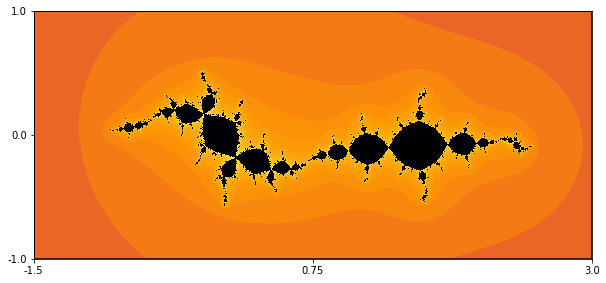

In [15]:
# Make the picture!
ydim,xdim = counts.shape[:2]
plt.imshow(counts**0.1, zorder=1, cmap="inferno")
plt.plot([0,xdim, xdim,0,0], [0, 0, ydim, ydim, 0], 'k')
ax = plt.gca()
ax.set_xlim(0,xdim)
ax.set_ylim(0,ydim)
ax.set_yticks([0,ydim/2,ydim])
ax.set_yticklabels([zmin.imag, (zmax.imag+zmin.imag)/2, zmax.imag])
ax.set_xticks([0,xdim/2,xdim])
supress = ax.set_xticklabels([zmin.real, (zmax.real+zmin.real)/2, zmax.real])

fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(10)

# Uncomment this, if you want to save the image to a file.
# plt.savefig('neutral_escape.png',  bbox_inches='tight')

In [ ]:
# Here are a few more polynomials you might try

#def f(z): return z**2 - 1
#def f(z): return 3*z/np.sqrt(2) - z**3
#def f(z): return z+z**5
#def f(z): return z**3-z-1


# Sometimes, you might need to adjust the parameters at the top of the file.
# For example:

#def f(z): return -z**3 + (2.41154-0.133695j)*z**2 - (0.090706-0.27145j)
#zmin = -1.5-1j
#zmax = 3+1j
#max_iters = 50
#max_size_squared = 10
#resolution = 1200

There's a groovy trick called *boundary scanning* that allows us to highlight just the Julia set itself.

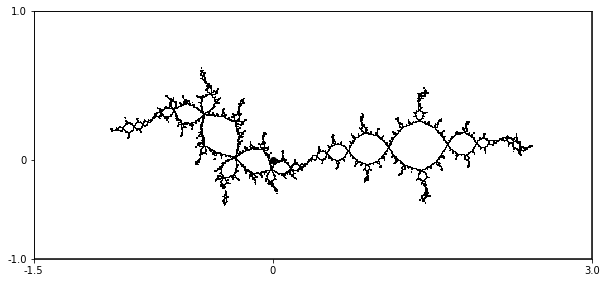

In [16]:
from scipy.ndimage import convolve
convolved = convolve(np.sign(counts), [[1,1,1],[1,-8,1],[1,1,1]])
plt.imshow(np.sign(np.abs(convolved)), cmap='Greys')
plt.plot([0,xdim, xdim,0,0], [0, 0, ydim, ydim, 0], 'k')
yres,xres = counts.shape[:2]
ax = plt.gca()
ax.set_xlim(0,xdim)
ax.set_ylim(0,ydim)
ax.set_yticks([0,yres/2,yres])
ax.set_yticklabels([zmin.imag, (zmax.imag+zmin.imag)/2, zmax.imag])
ax.set_xticks([0,xres/2,xres])
ax.set_xticklabels([zmin.real, (zmax.real+zmin.real)/2, zmax.real])

def scaler(domain_min, domain_max, range_min, range_max):
    def scale(x):
        return (-domain_min*range_max + domain_max*range_min + \
            (range_max - range_min)*x)/(domain_max - domain_min)
    return scale

xscale = scaler(-1.5,2, 0, xres)
yscale = scaler(-1,1.5, 0, yres)
ax.set_yticks([0,yscale(0),yres])
ax.set_yticklabels([zmin.imag, 0, zmax.imag])
ax.set_xticks([0,xscale(0),xres])
ax.set_xticklabels([zmin.real, 0, zmax.real])
plt.plot(xscale(0), yscale(0),'ko')

fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(10)
plt.savefig('temp.png',  bbox_inches='tight')

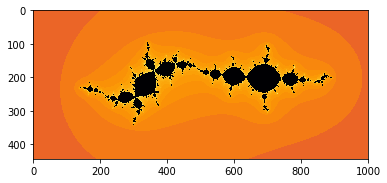

In [17]:
plt.imshow(counts**0.1, zorder=1, cmap="inferno")

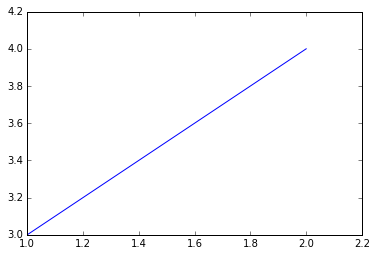

In [9]:
plt.plot([1,2],[3,4])